In [1]:
%tensorflow_version 1.X
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


##Download data

In [2]:
!mkdir tmp

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O tmp/rps-test-set.zip

--2020-08-12 01:02:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 2404:6800:4008:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘tmp/rps.zip’

tmp/rps.zip         100%[===================>] 191.38M  25.7MB/s    in 7.4s    

2020-08-12 01:02:55 (25.7 MB/s) - ‘tmp/rps.zip’ saved [200682221/200682221]

--2020-08-12 01:02:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to

##Unzip data

In [2]:
import os
import zipfile

local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [3]:
rock_dir = os.path.join('tmp/rps/rock')
paper_dir = os.path.join('tmp/rps/paper')
scissors_dir = os.path.join('tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:5])

paper_files = os.listdir(paper_dir)
print(paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:5])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock02-085.png', 'rock02-069.png', 'rock07-k03-015.png', 'rock04-032.png', 'rock03-084.png']
['paper03-067.png', 'paper03-046.png', 'paper03-010.png', 'paper04-000.png', 'paper01-025.png']
['testscissors02-109.png', 'scissors01-104.png', 'scissors04-047.png', 'testscissors01-114.png', 'scissors02-009.png']


##View some data

tmp/rps/rock/rock02-085.png


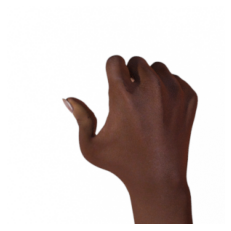

tmp/rps/rock/rock02-069.png


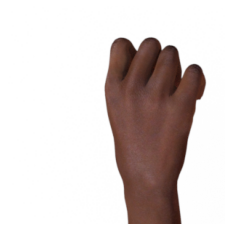

tmp/rps/paper/paper03-067.png


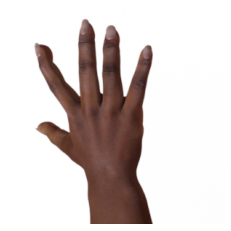

tmp/rps/paper/paper03-046.png


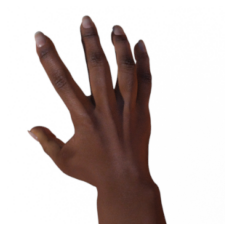

tmp/rps/scissors/testscissors02-109.png


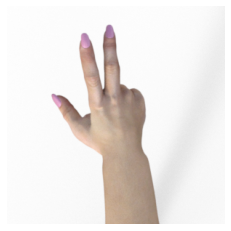

tmp/rps/scissors/scissors01-104.png


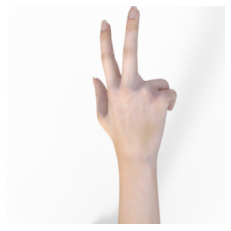

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Data pre-process

In [5]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import numpy as np

TRAINING_DIR = "tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### Check the labels

In [6]:
print('train_generator.classes\n',train_generator.classes)

train_generator.classes
 [0 0 0 ... 2 2 2]


In [7]:
# make sure two dictionaries are the same
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'paper', 1: 'rock', 2: 'scissors'}
{0: 'paper', 1: 'rock', 2: 'scissors'}


0


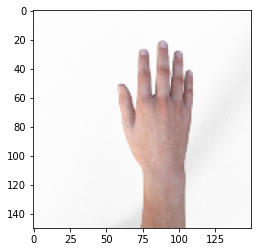

0


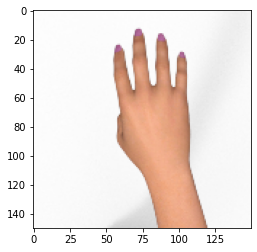

In [8]:
x,y = validation_generator.next()
for i in range(0,2):
    image = x[i]
    label = y[i]
    print(np.argmax(label))
    plt.imshow(image)
    plt.show()

## Make the model

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________

##Train the model and save it

In [10]:
history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)
model.save("rps.h5")

Epoch 1/25
79/79 [==============================] - 27s 339ms/step - loss: 1.2205 - acc: 0.3639 - val_loss: 1.2394 - val_acc: 0.3333
Epoch 2/25
79/79 [==============================] - 21s 268ms/step - loss: 0.9878 - acc: 0.5099 - val_loss: 0.4364 - val_acc: 0.9194
Epoch 3/25
79/79 [==============================] - 21s 271ms/step - loss: 0.6159 - acc: 0.7405 - val_loss: 0.1593 - val_acc: 0.9973
Epoch 4/25
79/79 [==============================] - 21s 270ms/step - loss: 0.4183 - acc: 0.8401 - val_loss: 0.1130 - val_acc: 0.9516
Epoch 5/25
79/79 [==============================] - 21s 271ms/step - loss: 0.3069 - acc: 0.8853 - val_loss: 0.0368 - val_acc: 1.0000
Epoch 6/25
79/79 [==============================] - 22s 275ms/step - loss: 0.2681 - acc: 0.8976 - val_loss: 0.0470 - val_acc: 1.0000
Epoch 7/25
79/79 [==============================] - 22s 280ms/step - loss: 0.2001 - acc: 0.9274 - val_loss: 0.0534 - val_acc: 0.9704
Epoch 8/25
79/79 [==============================] - 22s 275ms/step - 

##See the training trend

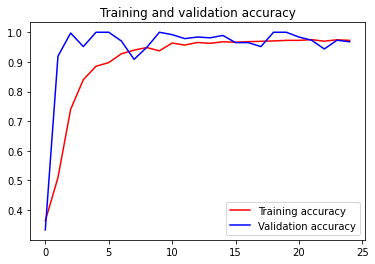

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

##Test the model

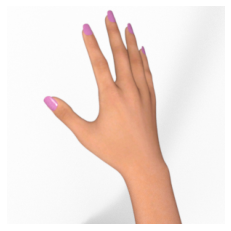

original image shape: (300, 300, 4)
the predict result is: [[0.72929627 0.00476386 0.26593992]]
predicted class: [0]
the folder name is: paper


In [24]:
from keras.preprocessing import image
import matplotlib.image as mpimg

path = "./tmp/rps-test-set/paper/testpaper01-01.png"

img = mpimg.imread(path)
plt.imshow(img)
plt.axis('Off')
plt.show()
print("original image shape:", img.shape)
 
# predicting images
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img) / 255  # remember to divide by 255
x = np.expand_dims(x, axis=0)

classes = model.predict(x)
print("the predict result is:", classes)

# predict_classes
classes = model.predict_classes(x)
print("predicted class:", classes)
class_name = labels[classes[0]]
print("the folder name is:", class_name)

Reference: https://youtu.be/u2TjZzNuly8?list=PLQY2H8rRoyvwLbzbnKJ59NkZvQAW9wLbx